## Faster-RCNN

In [2]:
#!pip install pycocotools

   ---------------------------------------- 0.0/85.8 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.8 kB ? eta -:--:--
   -------------- ------------------------- 30.7/85.8 kB 435.7 kB/s eta 0:00:01
   -------------------------------------- - 81.9/85.8 kB 762.6 kB/s eta 0:00:01
   ---------------------------------------- 85.8/85.8 kB 693.0 kB/s eta 0:00:00


### Learining

In [1]:
import os
import time
import datetime

import torch
import torch.utils.data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models.detection as M
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

from detection import coco_utils, presets, utils, transforms
from detection.engine import train_one_epoch, evaluate

In [ ]:
def get_dataset(img_root:str, file_name:str, train:bool=True):
  """Reimplementacja analogicznej funkcji z pakietu references, rozwiązująca drobną niekompatybilność w zbiorze CPD"""
  def fake_segmentation(image, target):
    for obj in target['annotations']:
      x, y, w, h = obj['bbox']
      segm = [x, y, x+w, y, x+w, y+h, x, y+h]
      obj['segmentation'] = [segm]
    return image, target

  tfs = transforms.Compose([
    fake_segmentation,
    coco_utils.ConvertCocoPolysToMask(),
    presets.DetectionPresetTrain(data_augmentation='hflip') if train else presets.DetectionPresetEval(),
    # can add augmentaiton
  ])
  ds = coco_utils.CocoDetection(img_root, file_name, transforms=tfs)
  return ds

In [ ]:
# Konfiguracja hiperparametrów
LR = 0.001 # powinno być dobrze dla 1 GPU
WDECAY = 0.0001
EPOCHS = 25
VAL_FREQ = 5 # walidacja i checkpointowanie co N epok
BATCH_SIZE = 2 
NUM_WORKERS = 0 
NUM_CLASSES = 14
DEVICE = 'cuda:0'
DATASET_ROOT = 'chess/'
OUTPUT_DIR = 'out2/'

In [4]:
# Zaczytanie datasetów
chess_train = get_dataset(os.path.join(DATASET_ROOT, 'train'), os.path.join(DATASET_ROOT, 'train/_annotations.coco.json'))
chess_val = get_dataset(os.path.join(DATASET_ROOT, 'valid'), os.path.join(DATASET_ROOT, 'valid/_annotations.coco.json'))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [5]:
# samplery i loadery
train_sampler = torch.utils.data.RandomSampler(chess_train)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)
train_loader = torch.utils.data.DataLoader(
  chess_train, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

val_sampler = torch.utils.data.SequentialSampler(chess_val)
val_loader = torch.utils.data.DataLoader(
  chess_val, batch_size=1, sampler=val_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

In [ ]:
model = M.fasterrcnn_resnet50_fpn(weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91).to(DEVICE)
# predyktor mniejszy, dostosowany do naszego zbioru:
model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_channels=1024, num_classes=NUM_CLASSES).to(DEVICE)

In [ ]:
model # (dlaczego tyle out_features?)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Train

In [ ]:
# Krótkie wstępne uczenie losowo zainicjowanego predyktora:
train_one_epoch(
  model=model,
  optimizer=torch.optim.AdamW(model.roi_heads.box_predictor.parameters(), lr=LR, weight_decay=WDECAY),
  data_loader=train_loader,
  device=DEVICE,
  epoch=0, print_freq=20, scaler=None
)

In [8]:
# Uczenie pełnego modelu
optimizer = torch.optim.AdamW(
  [p for p in model.parameters() if p.requires_grad],
  lr=LR,
  weight_decay=WDECAY
)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1) # dobierz wartości jeśli trzeba

In [9]:
start_time = time.time()
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, 20, None)
    lr_scheduler.step()

    # eval and checkpoint every VAL_FREQ epochs
    if (epoch+1) % VAL_FREQ == 0:
      checkpoint = {
          "model": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "lr_scheduler": lr_scheduler.state_dict(),
          "epoch": epoch,
      }
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, f"model_{epoch}.pth"))
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, "checkpoint.pth"))
      evaluate(model, val_loader, device=DEVICE)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Epoch: [0]  [  0/101]  eta: 0:01:57  lr: 0.000011  loss: 1.5846 (1.5846)  loss_classifier: 0.5000 (0.5000)  loss_box_reg: 0.3734 (0.3734)  loss_objectness: 0.6530 (0.6530)  loss_rpn_box_reg: 0.0581 (0.0581)  time: 1.1585  data: 0.4260  max mem: 2674
Epoch: [0]  [ 20/101]  eta: 0:01:28  lr: 0.000211  loss: 0.6247 (0.6966)  loss_classifier: 0.3521 (0.3685)  loss_box_reg: 0.2152 (0.2396)  loss_objectness: 0.0053 (0.0666)  loss_rpn_box_reg: 0.0167 (0.0219)  time: 1.0948  data: 0.3703  max mem: 2884
Epoch: [0]  [ 40/101]  eta: 0:01:14  lr: 0.000411  loss: 0.5012 (0.5782)  loss_classifier: 0.1970 (0.2902)  loss_box_reg: 0.2539 (0.2339)  loss_objectness: 0.0007 (0.0354)  loss_rpn_box_reg: 0.0124 (0.0188)  time: 1.3451  data: 0.3318  max mem: 2884
Epoch: [0]  [ 60/101]  eta: 0:01:07  lr: 0.000610  loss: 0.4708 (0.5670)  loss_classifier: 0.1945 (0.2755)  loss_box_reg: 0.2445 (0.2452)  loss_objectness: 0.0018 (0.0251)  loss_rpn_box_reg: 0.0246 (0.0212)  time: 2.5203  data: 0.3663  max mem: 2899


### Load

In [8]:
checkpoint_path = 'out2/model_24.pth'
checkpoint = torch.load(checkpoint_path)

# Załaduj wagi do modelu
model.load_state_dict(checkpoint['model'])
optimizer = torch.optim.AdamW(
  [p for p in model.parameters() if p.requires_grad],
  lr=LR,
  weight_decay=WDECAY
)

optimizer.load_state_dict(checkpoint['optimizer'])

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
model.to(DEVICE)
pass

In [9]:
# Inferencja na zadanym obrazie
preprocess = M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms() # to wystarczy pobrać raz
img = read_image(os.path.join(DATASET_ROOT, 'test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg'))
model.eval()
batch = [preprocess(img).to(DEVICE)]
prediction = model(batch)[0]

# Rysowanie predykcji - wygodny gotowiec
box = draw_bounding_boxes(
  img,
  boxes=prediction['boxes'],
  labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
  colors='red',
  width=4,
)
to_pil_image(box.detach()).show()

---
### RoIHeads, nms_thresh, score_thresh

In [57]:
"""def evaluate_with_parameterss(model, data_loader, image_path, score_thresh=0.05, nms_thresh=0.5):
    # RoIHeads parameters
    # NMS - Non Maximum Suppression - nms_thresh -> all boxes with Intersection over Union greather than that number are discarded
    model.roi_heads.score_thresh = score_thresh
    model.roi_heads.nms_thresh = nms_thresh

    #evaluate(model, data_loader, device=DEVICE)
    img = read_image(image_path)
    batch = [preprocess(img).to(DEVICE)]
    prediction = model(batch)[0]

    return prediction"""

'def evaluate_with_parameterss(model, data_loader, image_path, score_thresh=0.05, nms_thresh=0.5):\n    # RoIHeads parameters\n    # NMS - Non Maximum Suppression - nms_thresh -> all boxes with Intersection over Union greather than that number are discarded\n    model.roi_heads.score_thresh = score_thresh\n    model.roi_heads.nms_thresh = nms_thresh\n\n    #evaluate(model, data_loader, device=DEVICE)\n    img = read_image(image_path)\n    batch = [preprocess(img).to(DEVICE)]\n    prediction = model(batch)[0]\n\n    return prediction'

In [15]:
# abb = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=0.01, nms_thresh=10)

In [16]:
"""path_tmp = selected_images[0]

# Initialize subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))


subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=0.01, nms_thresh=10)
axs[1, 1].imshow(subplot)
axs[1, 1].set_title(f"Score Thresh: {1}, NMS Thresh: {1}")
axs[1, 1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()"""

'path_tmp = selected_images[0]\n\n# Initialize subplots\nfig, axs = plt.subplots(2, 2, figsize=(15, 15))\n\n\nsubplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=0.01, nms_thresh=10)\naxs[1, 1].imshow(subplot)\naxs[1, 1].set_title(f"Score Thresh: {1}, NMS Thresh: {1}")\naxs[1, 1].axis(\'off\')\n\n# Show the plot\nplt.tight_layout()\nplt.show()'

In [10]:
def evaluate_with_parameters(model, data_loader, image_path, score_thresh=0.05, nms_thresh=0.5):
    # RoIHeads parameters
    # NMS - Non Maximum Suppression - nms_thresh -> all boxes with Intersection over Union greather than that number are discarded
    model.roi_heads.score_thresh = score_thresh
    model.roi_heads.nms_thresh = nms_thresh
    model.eval()
    evaluate(model, data_loader, device=DEVICE)
    print("@")
    img = read_image(image_path)
    batch = [preprocess(img).to(DEVICE)]
    prediction = model(batch)[0]

    box = draw_bounding_boxes(
    image=img,
    boxes=prediction['boxes'],
    labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
    colors='red',
    width=4,
    )
    # zwróć subplot
    box = np.transpose(box, (1, 2, 0))
    return box

In [11]:
selected_images = [
                   "chess/valid/IMG_0310_JPG.rf.6cf8e3d4550948ac9e5efafc66f1cdfd.jpg",
                   "chess/valid/05ad7223827a29a8283f6c4b2490f52f_jpg.rf.5fb70e6e53b997c3015533194ea8e033.jpg",
                   "chess/wild/chesscom_fide.jpeg",
                   "chess/wild/chesscom_uscf.jpeg",
                   "chess/wild/shop.jpg",
                   "chess/wild/my.jpg"
                   ]

#### przyklad 1


Test:  [ 0/58]  eta: 0:00:12  model_time: 0.0853 (0.0853)  evaluator_time: 0.0040 (0.0040)  time: 0.2162  data: 0.1240  max mem: 3290
Test:  [57/58]  eta: 0:00:00  model_time: 0.1022 (0.1026)  evaluator_time: 0.0020 (0.0027)  time: 0.1854  data: 0.0785  max mem: 3290
Test: Total time: 0:00:11 (0.1926 s / it)
Averaged stats: model_time: 0.1022 (0.1026)  evaluator_time: 0.0020 (0.0027)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

c:\Users\admin\anaconda3\envs\www\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


Test:  [ 0/58]  eta: 0:00:12  model_time: 0.0946 (0.0946)  evaluator_time: 0.0000 (0.0000)  time: 0.2207  data: 0.1230  max mem: 3290
Test:  [57/58]  eta: 0:00:00  model_time: 0.0932 (0.0952)  evaluator_time: 0.0010 (0.0008)  time: 0.1769  data: 0.0753  max mem: 3290
Test: Total time: 0:00:10 (0.1769 s / it)
Averaged stats: model_time: 0.0932 (0.0952)  evaluator_time: 0.0010 (0.0008)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

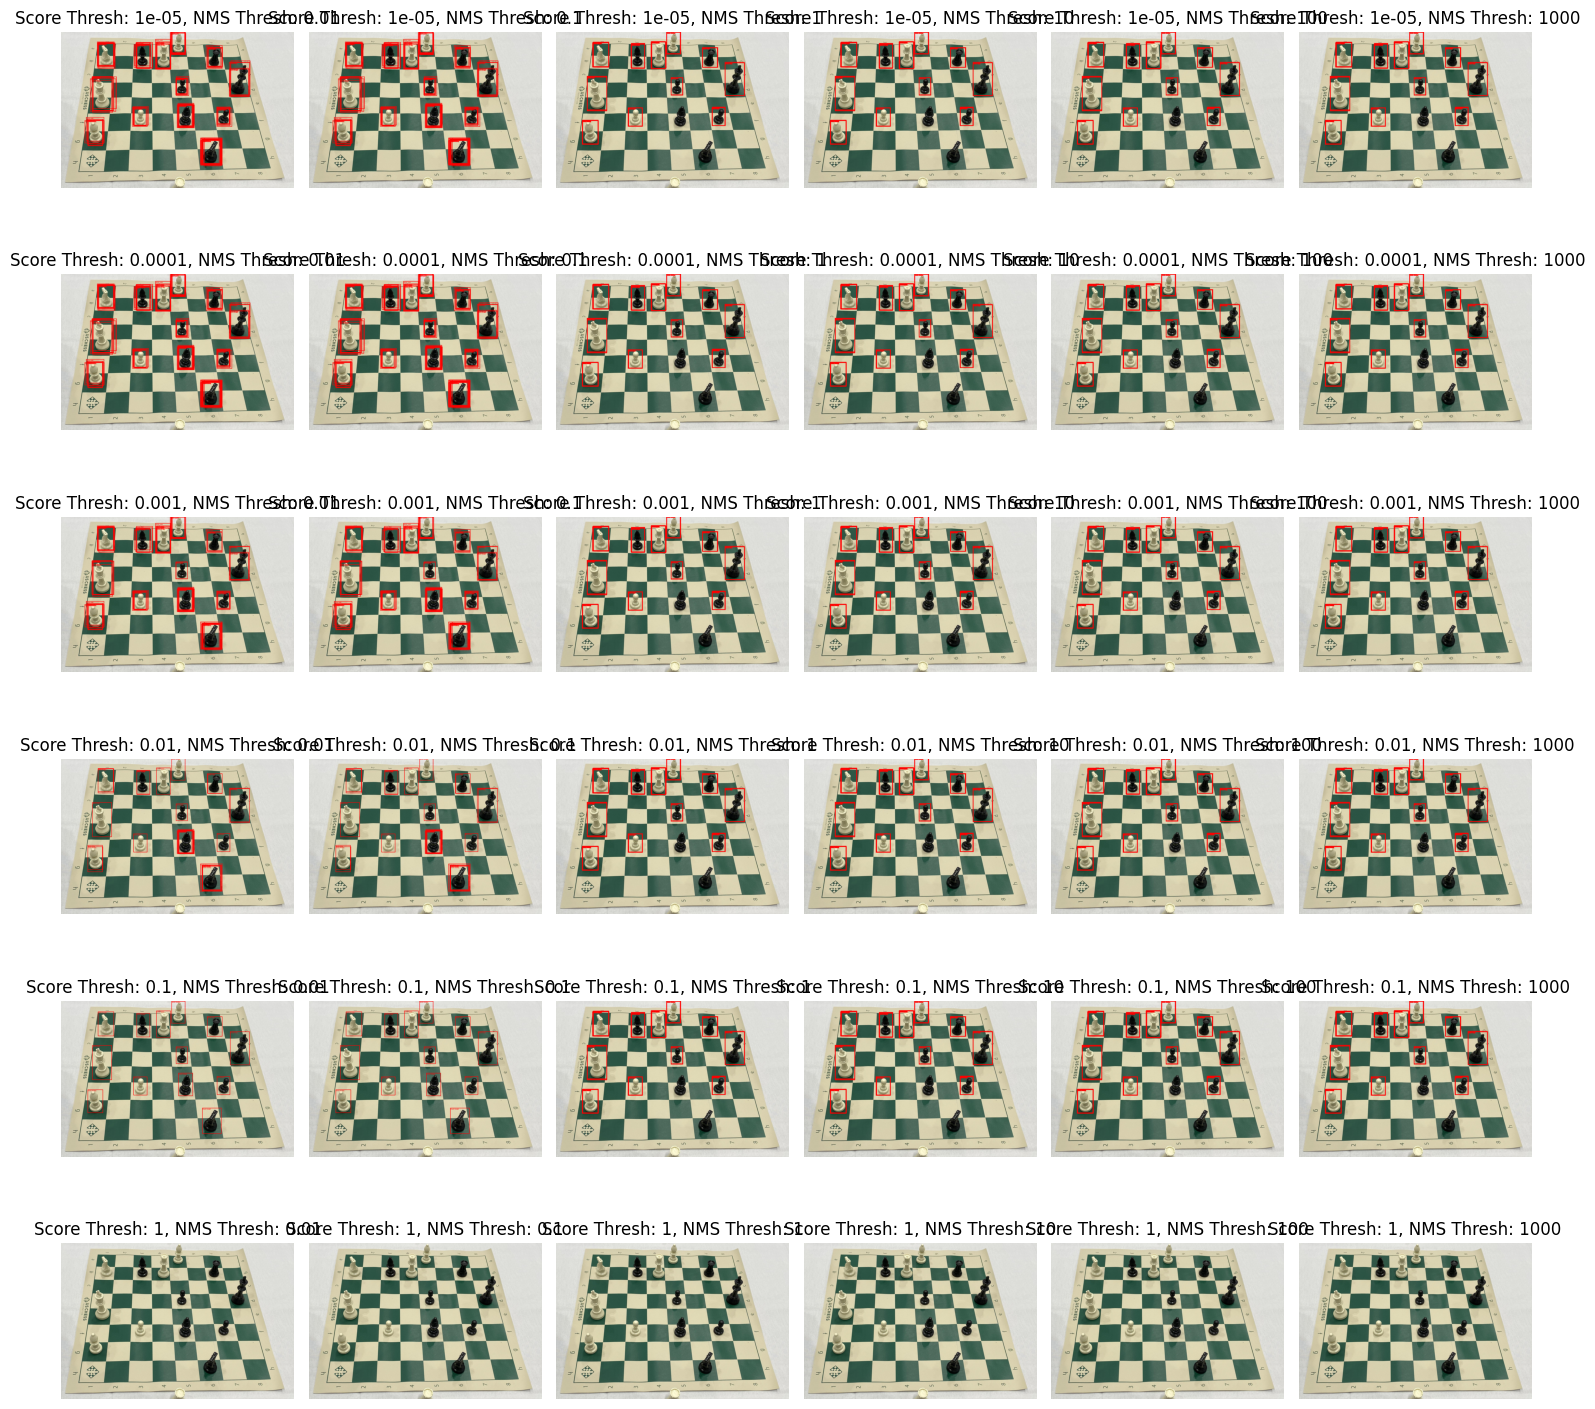

In [62]:
path_tmp = selected_images[0]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### przyklad 2



Test:  [ 0/58]  eta: 0:00:36  model_time: 0.1646 (0.1646)  evaluator_time: 0.0076 (0.0076)  time: 0.6239  data: 0.4393  max mem: 2127
Test:  [57/58]  eta: 0:00:00  model_time: 0.0693 (0.0737)  evaluator_time: 0.0049 (0.0059)  time: 0.2540  data: 0.1715  max mem: 2127
Test: Total time: 0:00:15 (0.2688 s / it)
Averaged stats: model_time: 0.0693 (0.0737)  evaluator_time: 0.0049 (0.0059)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

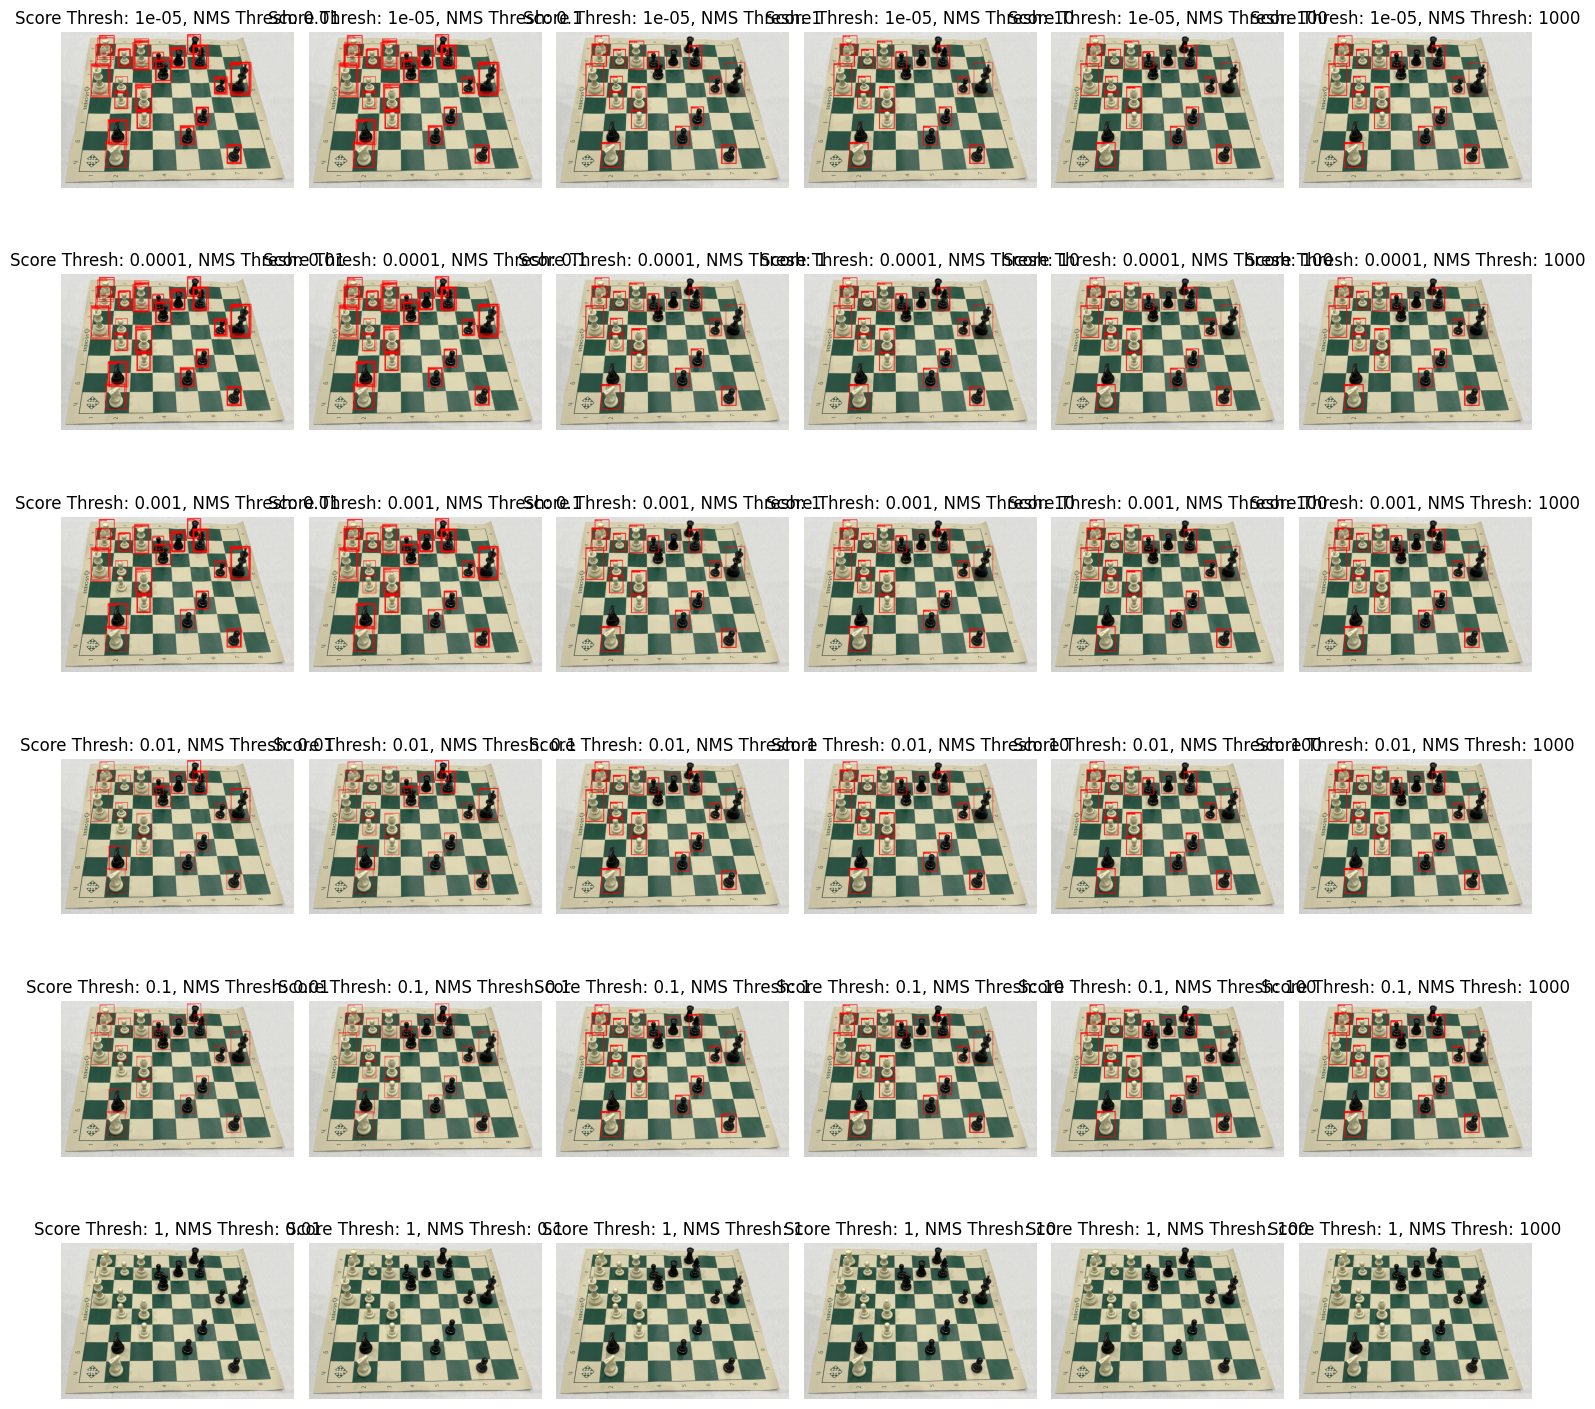

In [16]:
path_tmp = selected_images[1]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### przyklad 3



Test:  [ 0/58]  eta: 0:00:23  model_time: 0.2509 (0.2509)  evaluator_time: 0.0030 (0.0030)  time: 0.4108  data: 0.1459  max mem: 2127
Test:  [57/58]  eta: 0:00:00  model_time: 0.0629 (0.0672)  evaluator_time: 0.0020 (0.0026)  time: 0.1488  data: 0.0779  max mem: 2127
Test: Total time: 0:00:09 (0.1558 s / it)
Averaged stats: model_time: 0.0629 (0.0672)  evaluator_time: 0.0020 (0.0026)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

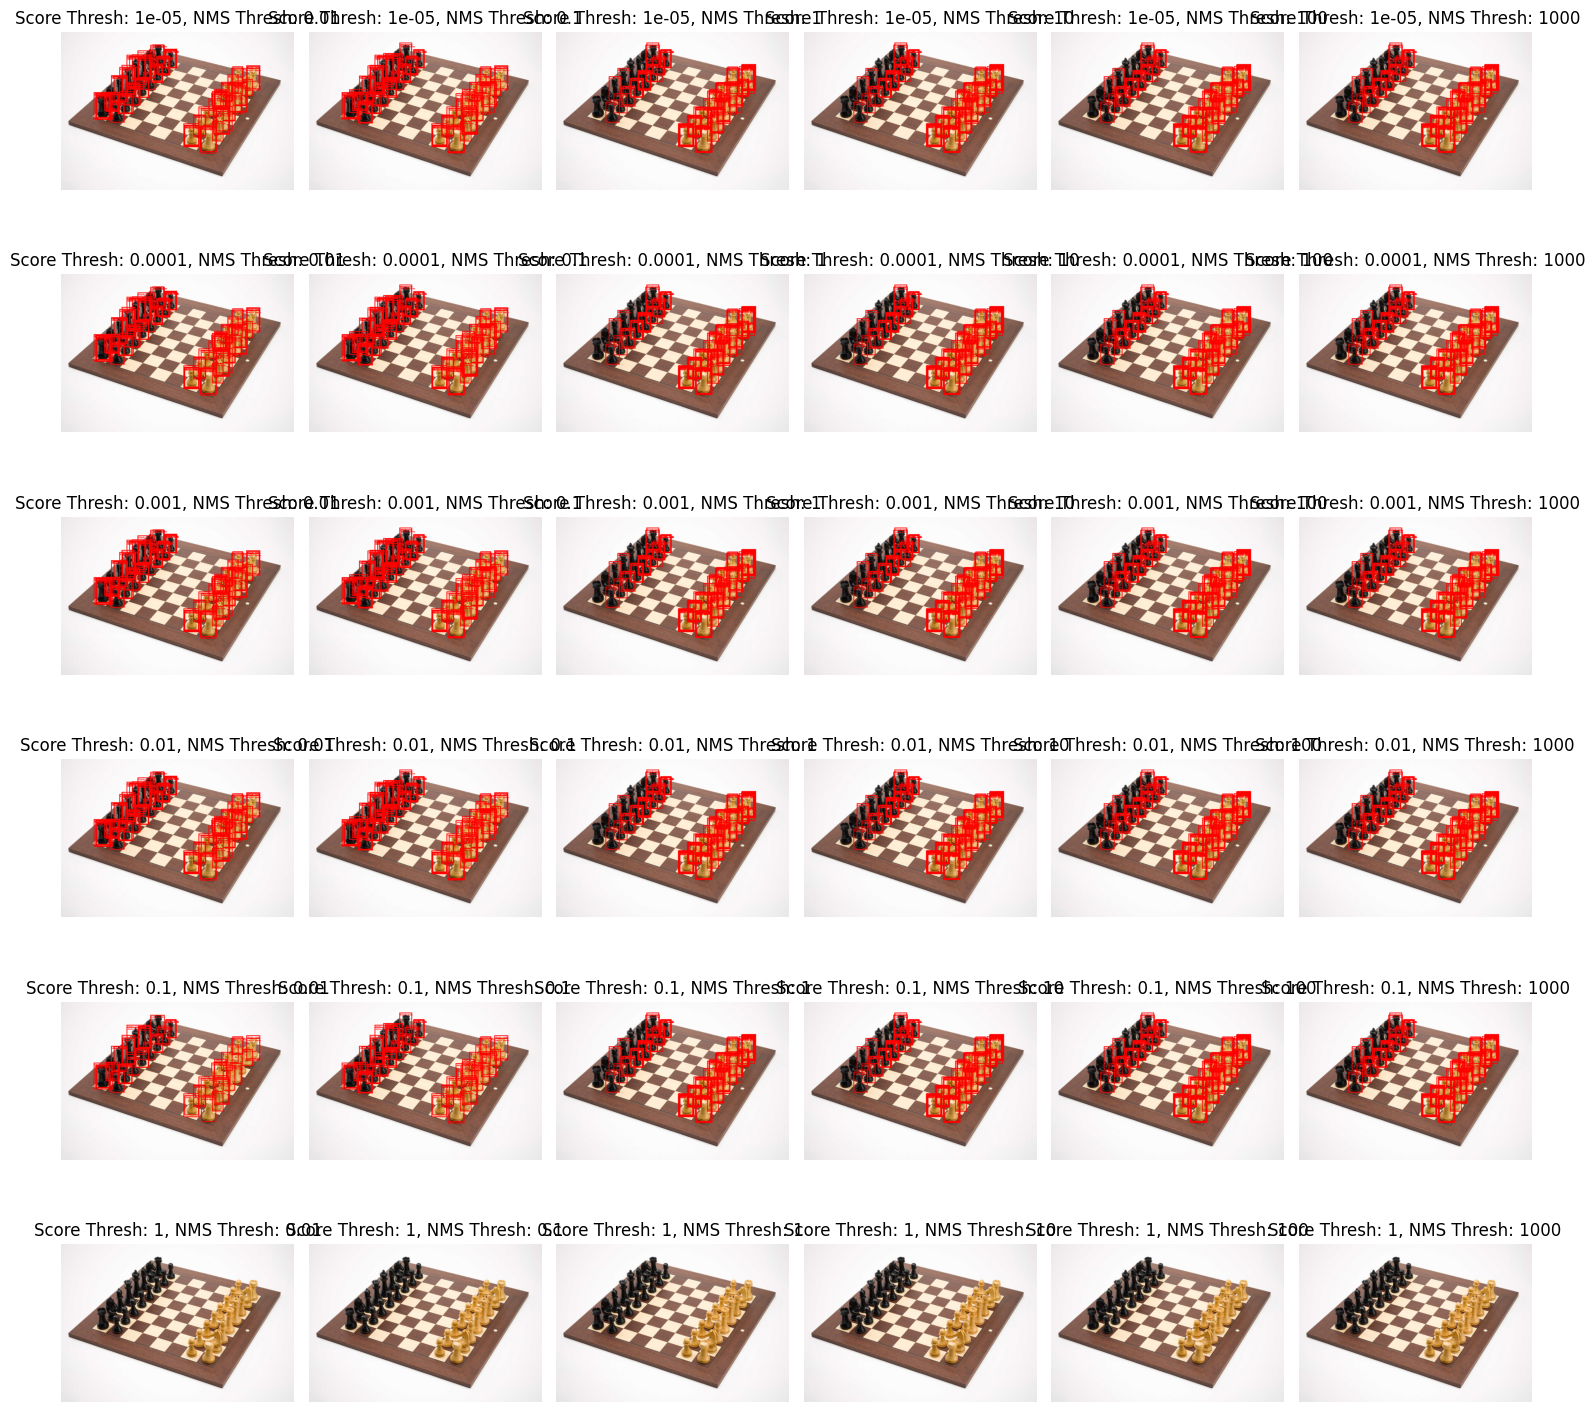

In [17]:
path_tmp = selected_images[2]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### przyklad 4


Test:  [ 0/58]  eta: 0:00:18  model_time: 0.1546 (0.1546)  evaluator_time: 0.0041 (0.0041)  time: 0.3215  data: 0.1588  max mem: 2127
Test:  [57/58]  eta: 0:00:00  model_time: 0.0611 (0.0657)  evaluator_time: 0.0020 (0.0026)  time: 0.1488  data: 0.0803  max mem: 2127
Test: Total time: 0:00:09 (0.1558 s / it)
Averaged stats: model_time: 0.0611 (0.0657)  evaluator_time: 0.0020 (0.0026)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

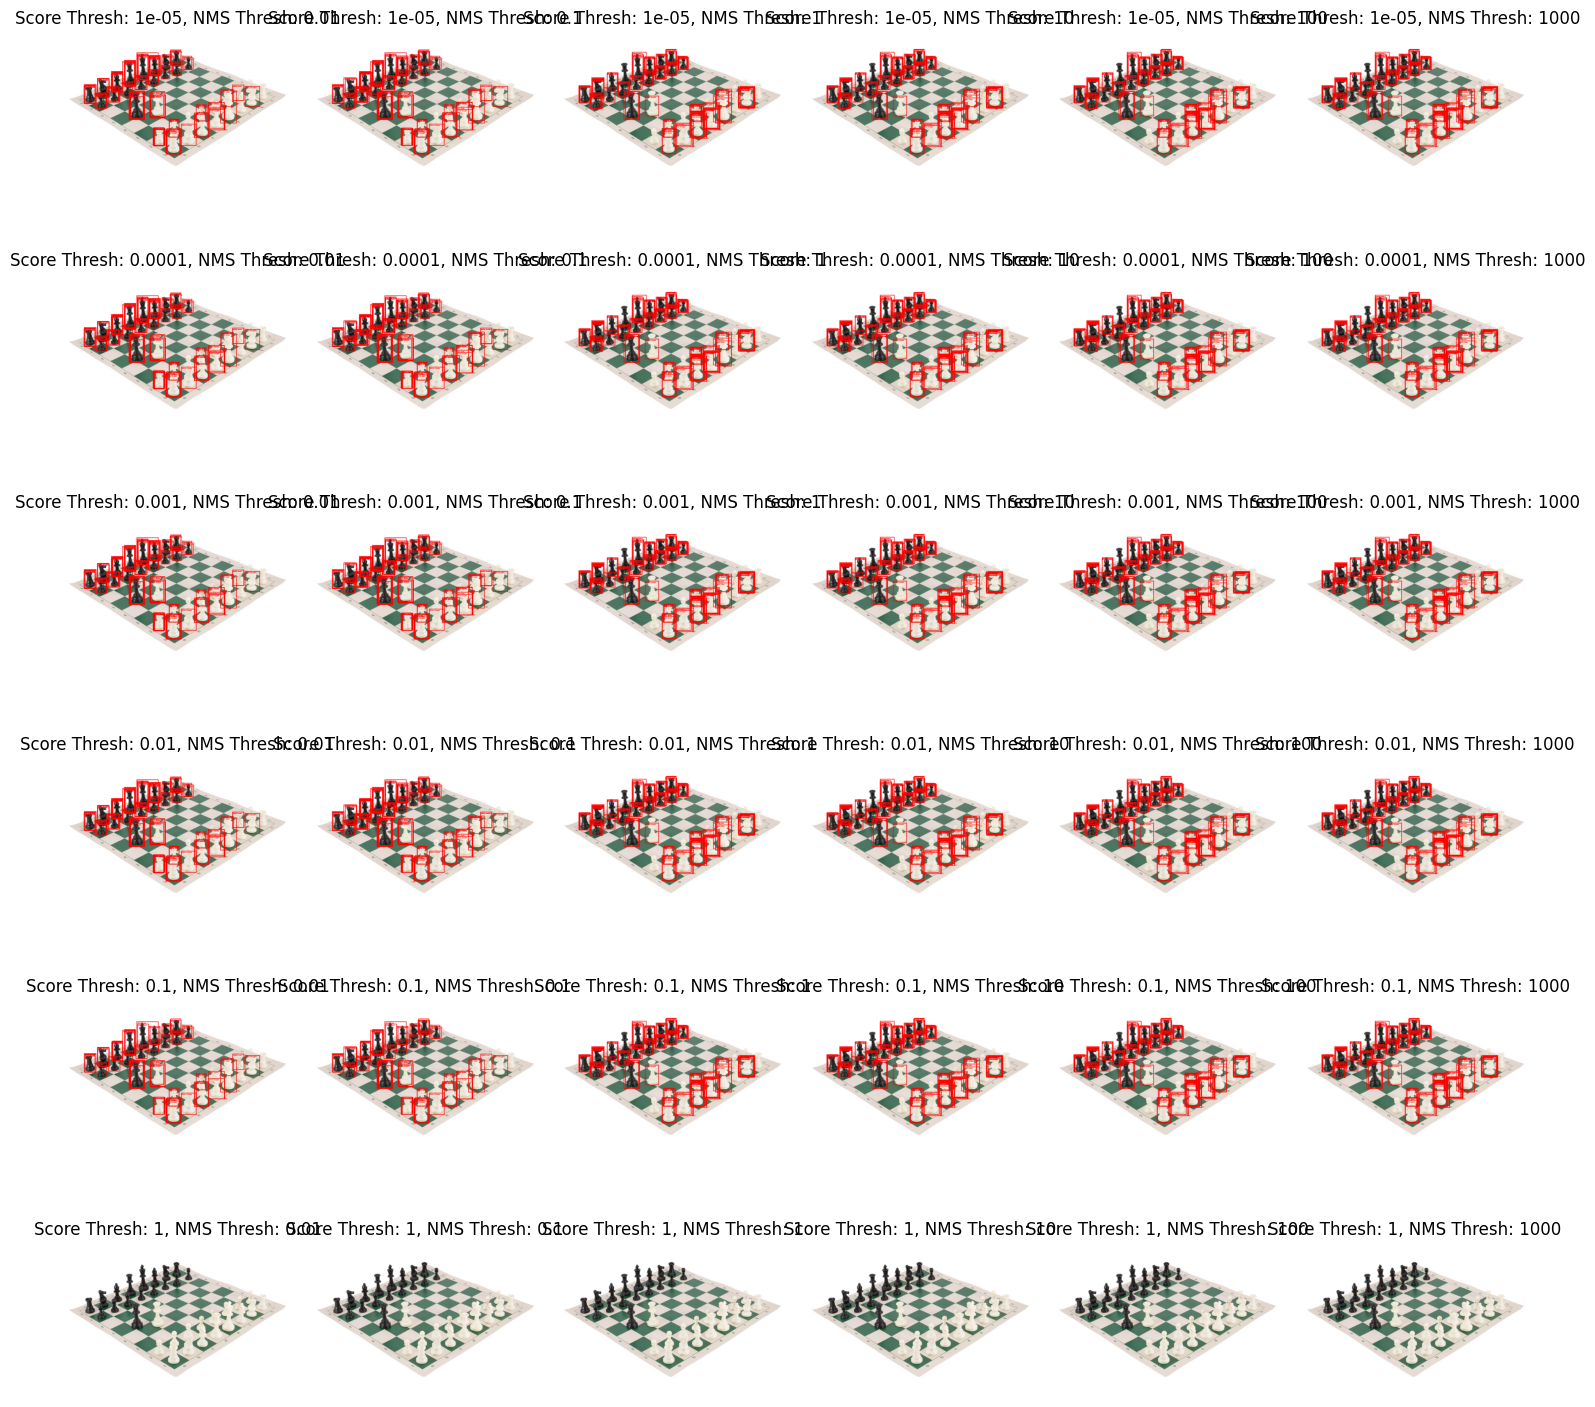

In [18]:
path_tmp = selected_images[3]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### przyklad 5


Test:  [ 0/58]  eta: 0:00:23  model_time: 0.2602 (0.2602)  evaluator_time: 0.0042 (0.0042)  time: 0.4028  data: 0.1344  max mem: 2127
Test:  [57/58]  eta: 0:00:00  model_time: 0.0633 (0.0661)  evaluator_time: 0.0020 (0.0025)  time: 0.1446  data: 0.0747  max mem: 2127
Test: Total time: 0:00:08 (0.1511 s / it)
Averaged stats: model_time: 0.0633 (0.0661)  evaluator_time: 0.0020 (0.0025)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

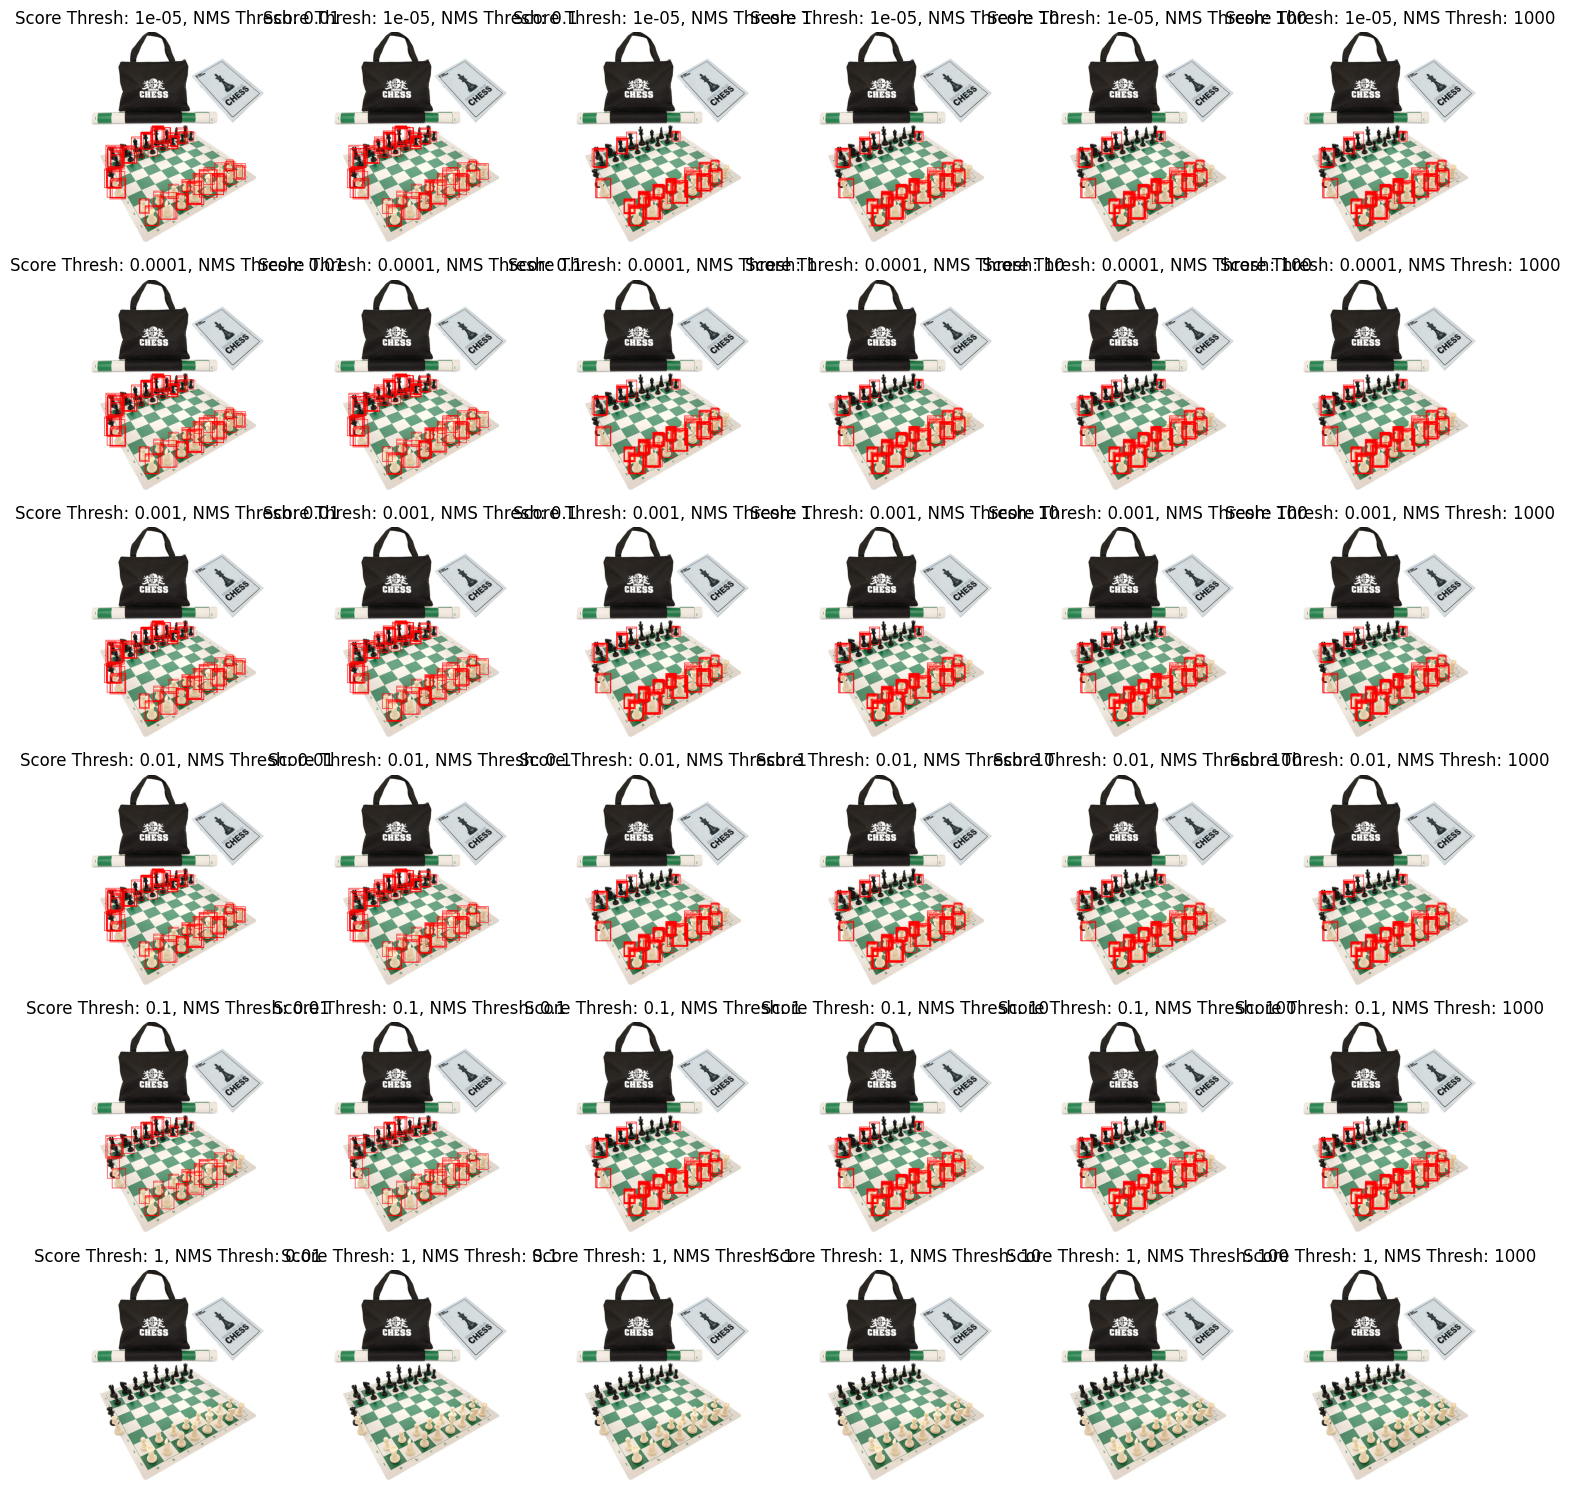

In [19]:
path_tmp = selected_images[4]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### przyklad 6


Test:  [ 0/58]  eta: 0:00:11  model_time: 0.0596 (0.0596)  evaluator_time: 0.0030 (0.0030)  time: 0.1979  data: 0.1316  max mem: 2127
Test:  [57/58]  eta: 0:00:00  model_time: 0.0740 (0.0690)  evaluator_time: 0.0051 (0.0037)  time: 0.2696  data: 0.1771  max mem: 2127
Test: Total time: 0:00:11 (0.1915 s / it)
Averaged stats: model_time: 0.0740 (0.0690)  evaluator_time: 0.0051 (0.0037)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

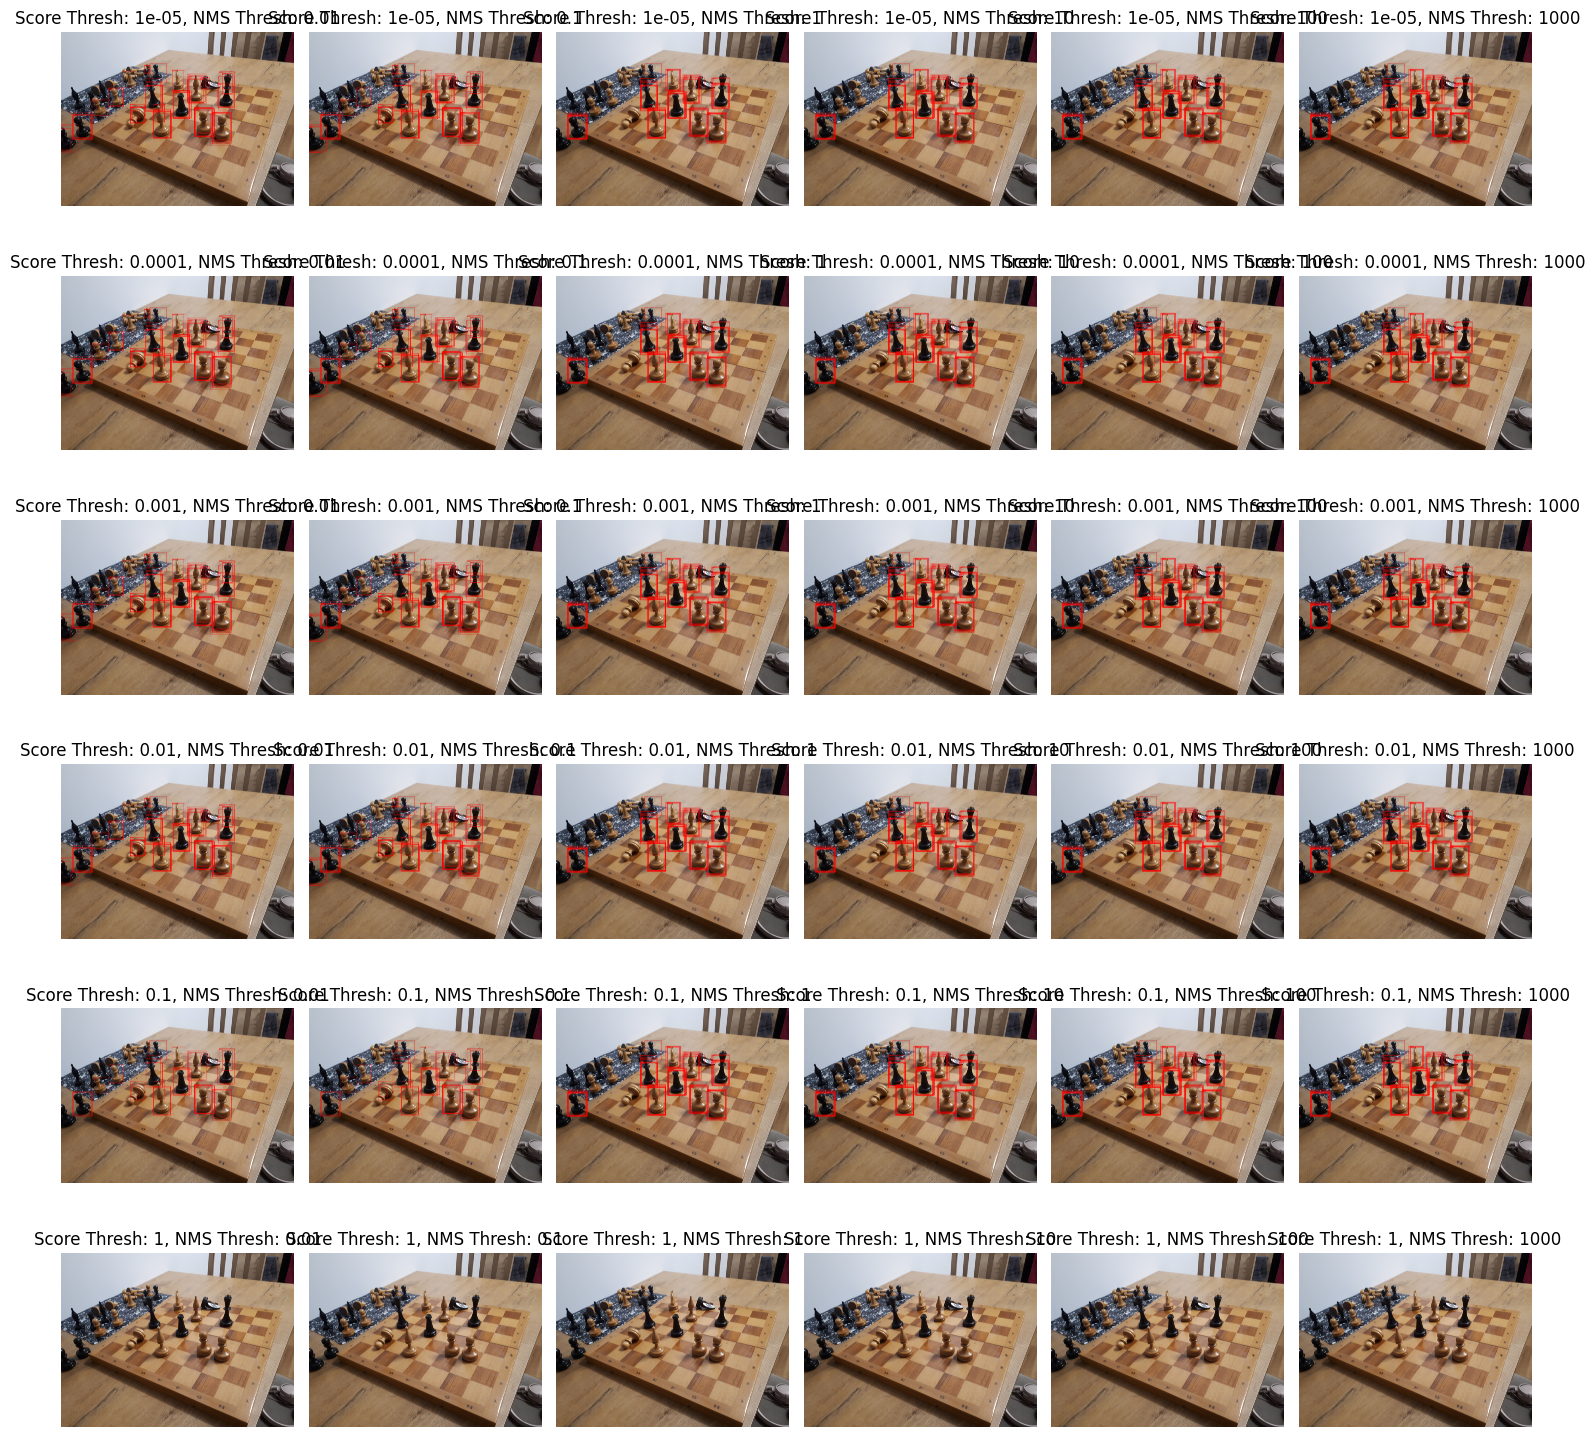

In [20]:
path_tmp = selected_images[5]
score_threshes = [0.00001,0.0001, 0.001, 0.01, 0.1, 1]
nms_threshes = [0.01, 0.1, 1, 10, 100, 1000]

# Initialize subplots
fig, axs = plt.subplots(len(score_threshes), len(nms_threshes), figsize=(15, 15))

for i, score_thresh in enumerate(score_threshes):
    for j, nms_thresh in enumerate(nms_threshes):
        subplot = evaluate_with_parameters(model, val_loader, path_tmp, score_thresh=score_thresh, nms_thresh=nms_thresh)
        axs[i, j].imshow(subplot)
        axs[i, j].set_title(f"Score Thresh: {score_thresh}, NMS Thresh: {nms_thresh}")
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Propostions vs predictions


In [13]:
import matplotlib.pyplot as plt

In [12]:
from copy import deepcopy


def forwardd(model, images, targets=None, no_transform=False):  
    original_image_sizes = []
    for img in images:
        val = img.shape[-2:]
        torch._assert(
            len(val) == 2,
            f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
        )
        original_image_sizes.append((val[0], val[1]))
    images, targets = model.transform(images, targets)

    features = model.backbone(images.tensors)
    proposals, proposal_losses = model.rpn(images, features, targets)
    detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    
    detections_proposals = detections
    detections_proposals[0]['boxes'] = proposals[0]
    detections_proposals = model.transform.postprocess(detections_proposals, images.image_sizes, original_image_sizes)
    if no_transform:
        detections_proposals[0]['boxes'] = proposals[0]
    #detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)[0]
    return detections_proposals
    #proposals = model.transform.postprocess(proposals, images.image_sizes, original_image_sizes)[0]
    """original_width, original_height = image.width, image.height
    proposals[:, 0] *= original_width
    proposals[:, 1] *= original_height
    proposals[:, 2] *= original_width
    proposals[:, 3] *= original_height"""
    
    box = draw_bounding_boxes(
        image=img,
        boxes=detections_proposals['boxes'],
        labels=[chess_train.coco.cats[i.item()]['name'] for i in detections_proposals['labels']],
        colors='red',
        width=4,
    )
    box = np.transpose(box, (1, 2, 0))
    to_pil_image(box.detach()).show()

In [14]:
def get_box(detections, image):
    print(detections['boxes'].shape)
    box = draw_bounding_boxes(
        image=image,
        boxes=detections['boxes'],
        #labels=[chess_train.coco.cats[i.item()]['name'] for i in aaa['labels']],
        colors='red',
        width=4,
    )
    box = np.transpose(box, (1, 2, 0))
    return box


In [24]:
image = read_image(os.path.join(DATASET_ROOT, 'test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg'))
image_tensor = preprocess(img).to(DEVICE)

detections_proposals = forwardd(model, [image_tensor], targets=None)[0]
detections = model([image_tensor])[0]

In [36]:
selected_images[0]

'chess/valid/IMG_0310_JPG.rf.6cf8e3d4550948ac9e5efafc66f1cdfd.jpg'

In [39]:
import matplotlib.image as mpimg

In [ ]:
image = read_image(selected_images[0])
image_tensor = preprocess(image).to(DEVICE)

nms_threshes = [0.00001, 0.1,0.25, 0.5, 0.75, 1, 100000]

# Initialize subplots
fig, axs = plt.subplots(len(nms_threshes), 2, figsize=(15, 15))

for i, nms_thresh in enumerate(nms_threshes):
    print(f"\nrpn.nms_thresh: {nms_thresh}")
    model.roi_heads.score_thresh = 0.001
    model.rpn.nms_thresh = nms_thresh
    model.eval()
    with torch.no_grad():
        detections = model([image_tensor])[0]
        detections_proposals = forwardd(model, [image_tensor], targets=None, no_transform=True)[0]
    
    box_prop = get_box(detections_proposals, image)
    axs[i, 1].imshow(box_prop)
    axs[i, 1].set_title(f"Proposals NMS Thresh: {nms_thresh}")
    axs[i, 1].axis('off')
    
    box = get_box(detections, image)
    axs[i, 0].imshow(box)
    axs[i, 0].set_title(f"Detection score_thresh: 0.01, NMS Thresh: {nms_thresh}")
    axs[i, 0].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### NMS & predictions quality and speed


#### Przykład 1



rpn.nms_thresh: 1e-05
torch.Size([109, 4])
torch.Size([38, 4])

rpn.nms_thresh: 0.1
torch.Size([133, 4])
torch.Size([39, 4])

rpn.nms_thresh: 0.25
torch.Size([256, 4])
torch.Size([40, 4])

rpn.nms_thresh: 0.5
torch.Size([688, 4])
torch.Size([65, 4])

rpn.nms_thresh: 0.75
torch.Size([1000, 4])
torch.Size([79, 4])

rpn.nms_thresh: 1
torch.Size([1000, 4])
torch.Size([63, 4])

rpn.nms_thresh: 100000
torch.Size([1000, 4])
torch.Size([63, 4])


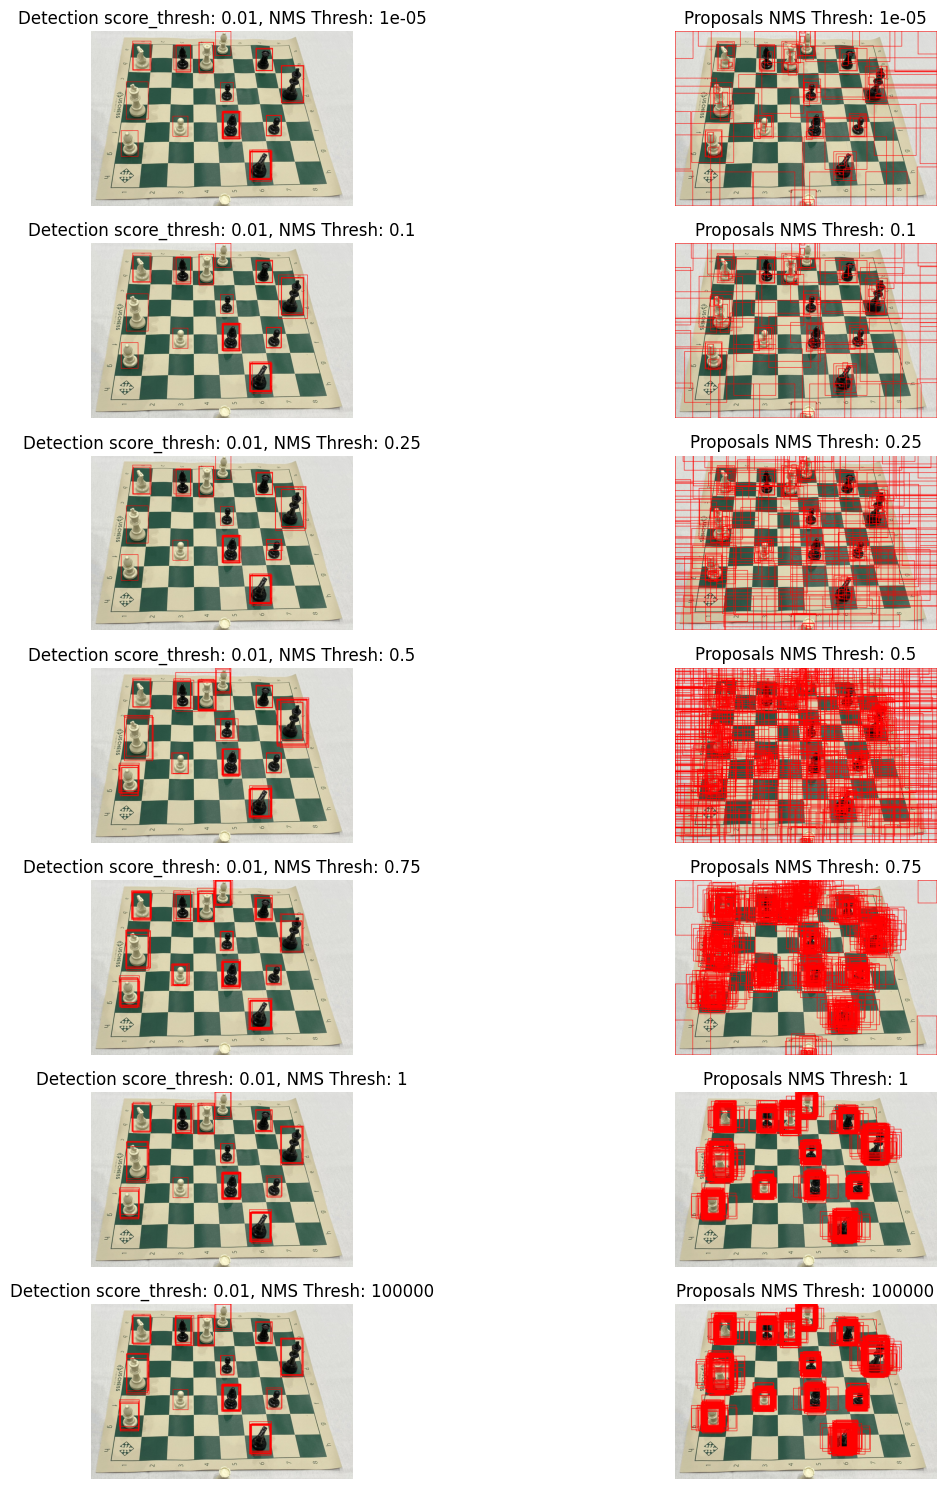

In [28]:
image = read_image(selected_images[0])
image_tensor = preprocess(image).to(DEVICE)

nms_threshes = [0.00001, 0.1,0.25, 0.5, 0.75, 1, 100000]

# Initialize subplots
fig, axs = plt.subplots(len(nms_threshes), 2, figsize=(15, 15))

for i, nms_thresh in enumerate(nms_threshes):
    print(f"\nrpn.nms_thresh: {nms_thresh}")
    model.roi_heads.score_thresh = 0.001
    model.rpn.nms_thresh = nms_thresh
    model.eval()
    with torch.no_grad():
        detections = model([image_tensor])[0]
        detections_proposals = forwardd(model, [image_tensor], targets=None)[0]
    
    box_prop = get_box(detections_proposals, image)
    axs[i, 1].imshow(box_prop)
    axs[i, 1].set_title(f"Proposals NMS Thresh: {nms_thresh}")
    axs[i, 1].axis('off')
    
    box = get_box(detections, image)
    axs[i, 0].imshow(box)
    axs[i, 0].set_title(f"Detection score_thresh: 0.01, NMS Thresh: {nms_thresh}")
    axs[i, 0].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Przykład 4


rpn.nms_thresh: 1e-05
torch.Size([90, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.1
torch.Size([133, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.25
torch.Size([232, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.5
torch.Size([694, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.75
torch.Size([1000, 4])
torch.Size([100, 4])

rpn.nms_thresh: 1
torch.Size([1000, 4])
torch.Size([100, 4])

rpn.nms_thresh: 100000
torch.Size([1000, 4])
torch.Size([100, 4])


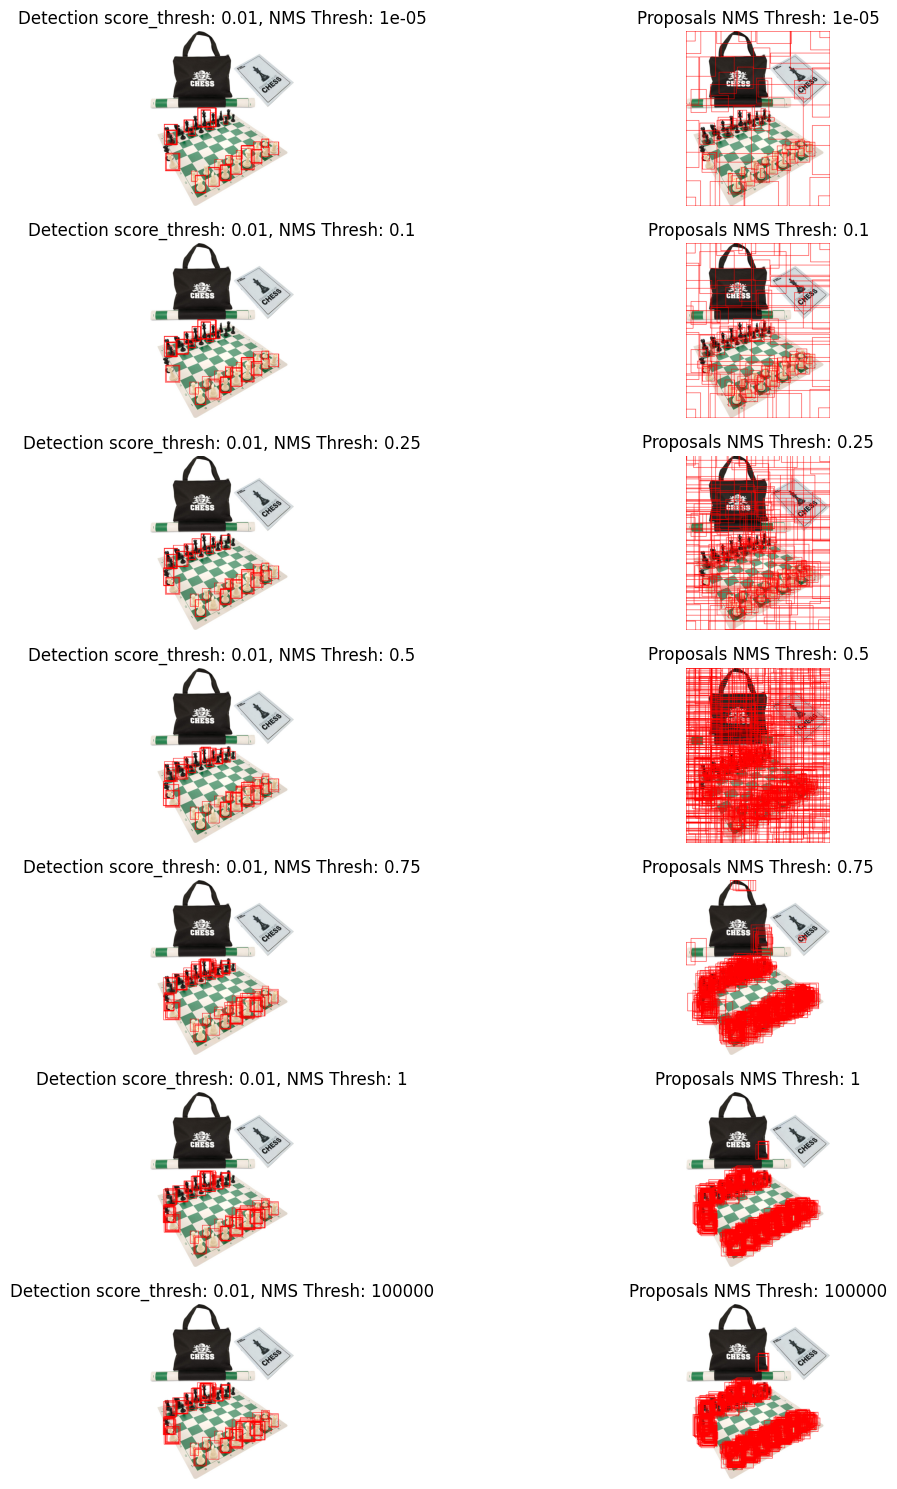

In [17]:
image = read_image(selected_images[4])
image_tensor = preprocess(image).to(DEVICE)

nms_threshes = [0.00001, 0.1,0.25, 0.5, 0.75, 1, 100000]

# Initialize subplots
fig, axs = plt.subplots(len(nms_threshes), 2, figsize=(15, 15))

for i, nms_thresh in enumerate(nms_threshes):
    print(f"\nrpn.nms_thresh: {nms_thresh}")
    model.roi_heads.score_thresh = 0.001
    model.rpn.nms_thresh = nms_thresh
    model.eval()
    with torch.no_grad():
        detections = model([image_tensor])[0]
        detections_proposals = forwardd(model, [image_tensor], targets=None)[0]
    
    box_prop = get_box(detections_proposals, image)
    axs[i, 1].imshow(box_prop)
    axs[i, 1].set_title(f"Proposals NMS Thresh: {nms_thresh}")
    axs[i, 1].axis('off')
    
    box = get_box(detections, image)
    axs[i, 0].imshow(box)
    axs[i, 0].set_title(f"Detection score_thresh: 0.01, NMS Thresh: {nms_thresh}")
    axs[i, 0].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Przykłąd 6



rpn.nms_thresh: 1e-05
torch.Size([99, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.1
torch.Size([131, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.25
torch.Size([243, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.5
torch.Size([698, 4])
torch.Size([100, 4])

rpn.nms_thresh: 0.75
torch.Size([1000, 4])
torch.Size([100, 4])

rpn.nms_thresh: 1
torch.Size([1000, 4])
torch.Size([100, 4])

rpn.nms_thresh: 100000
torch.Size([1000, 4])
torch.Size([100, 4])


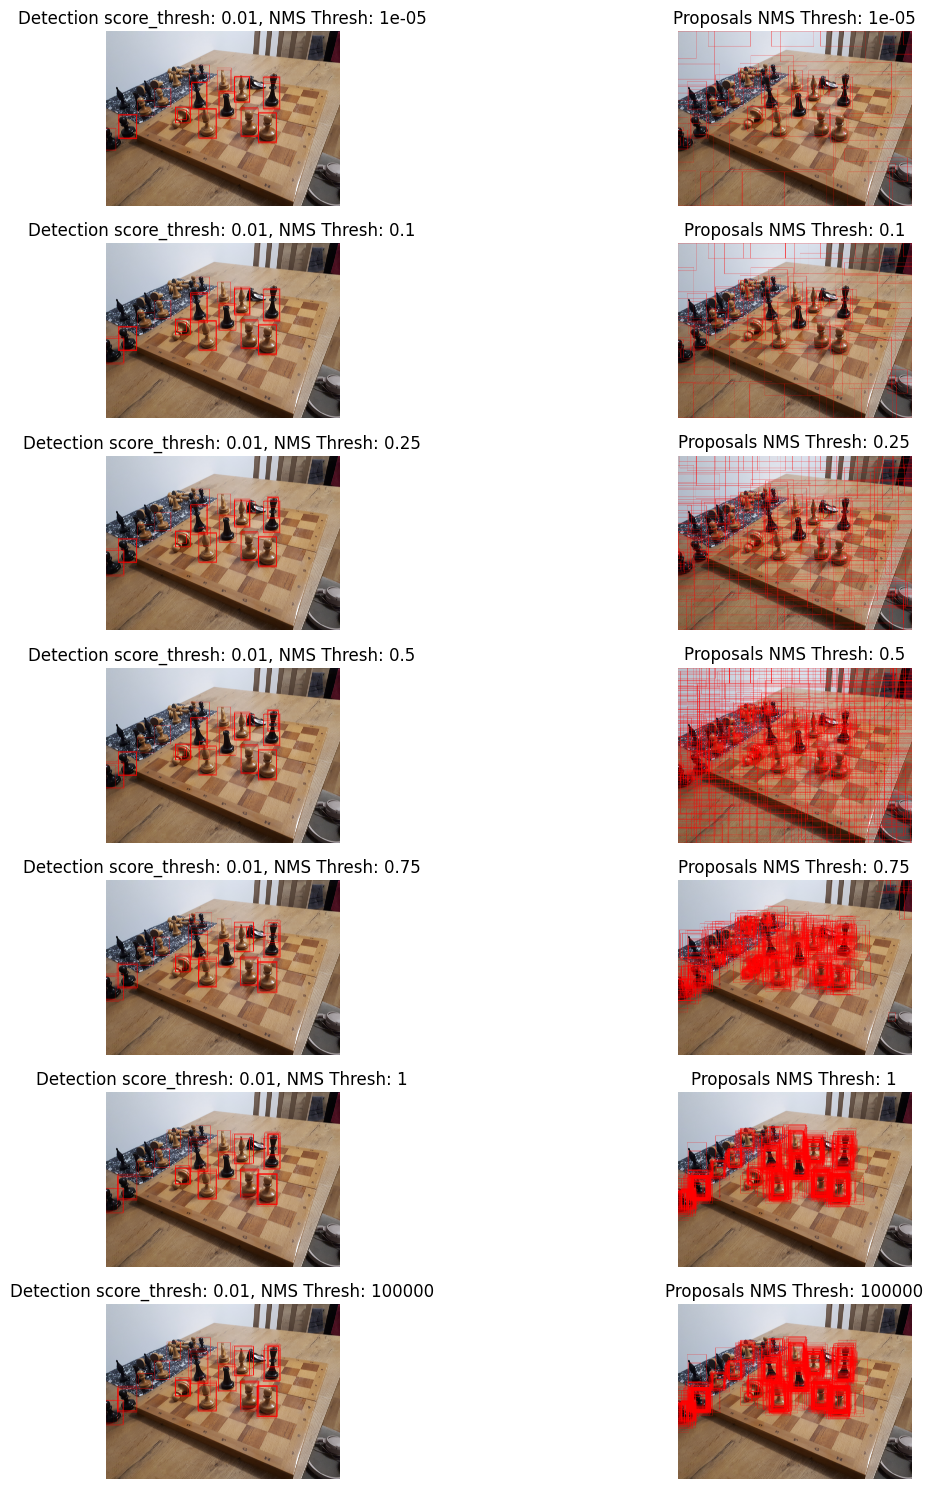

In [18]:
image = read_image(selected_images[5])
image_tensor = preprocess(image).to(DEVICE)

nms_threshes = [0.00001, 0.1,0.25, 0.5, 0.75, 1, 100000]

# Initialize subplots
fig, axs = plt.subplots(len(nms_threshes), 2, figsize=(15, 15))

for i, nms_thresh in enumerate(nms_threshes):
    print(f"\nrpn.nms_thresh: {nms_thresh}")
    model.roi_heads.score_thresh = 0.001
    model.rpn.nms_thresh = nms_thresh
    model.eval()
    with torch.no_grad():
        detections = model([image_tensor])[0]
        detections_proposals = forwardd(model, [image_tensor], targets=None)[0]
    
    box_prop = get_box(detections_proposals, image)
    axs[i, 1].imshow(box_prop)
    axs[i, 1].set_title(f"Proposals NMS Thresh: {nms_thresh}")
    axs[i, 1].axis('off')
    
    box = get_box(detections, image)
    axs[i, 0].imshow(box)
    axs[i, 0].set_title(f"Detection score_thresh: 0.01, NMS Thresh: {nms_thresh}")
    axs[i, 0].axis('off')

# Show the plot
plt.tight_layout()
plt.show()